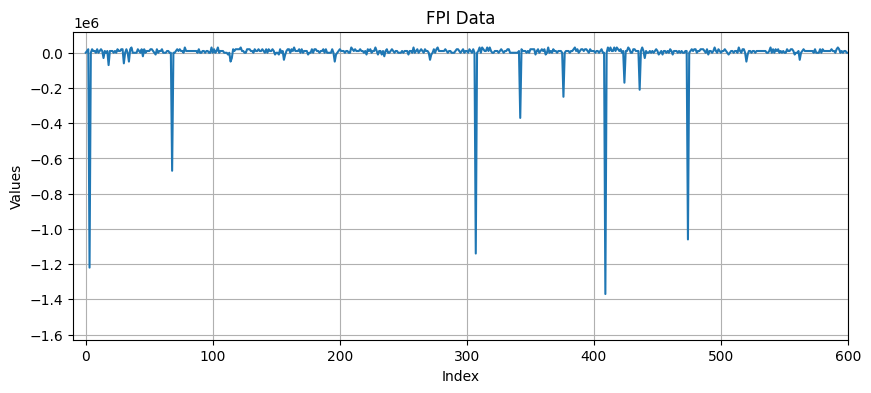

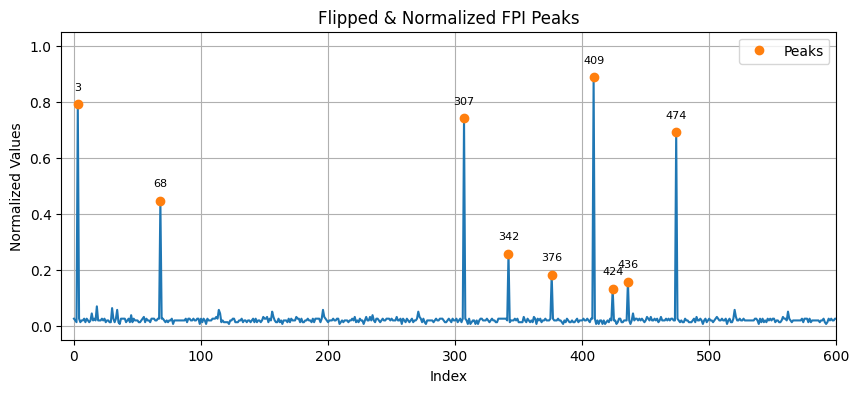

Average distance between peaks: 49.30722891566265
GHz per index: 0.02028100183262065


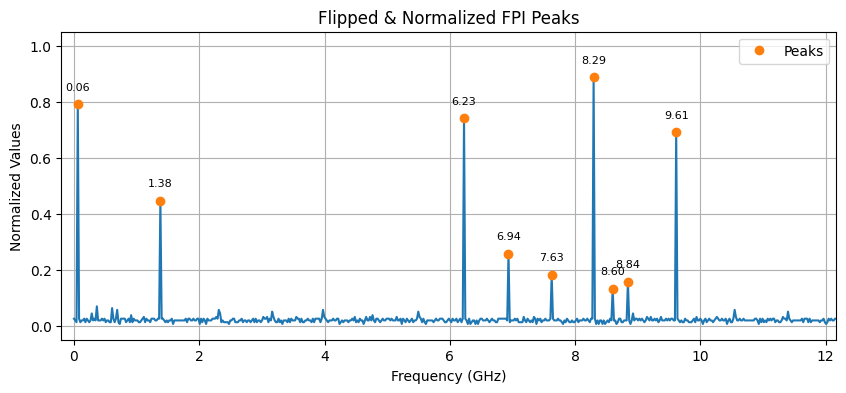

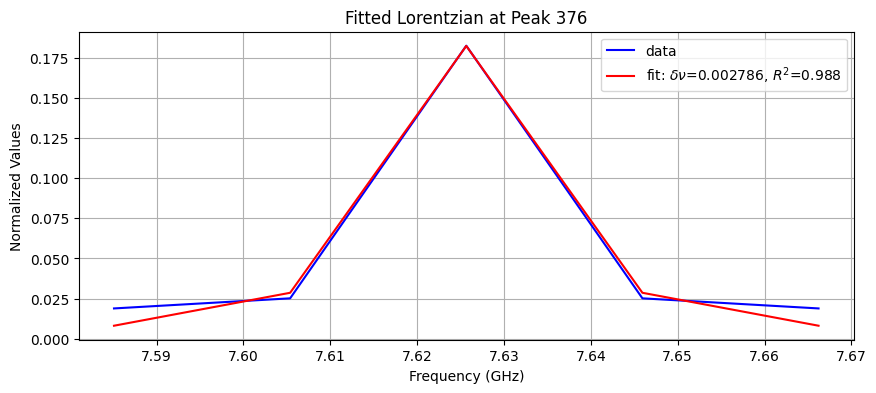

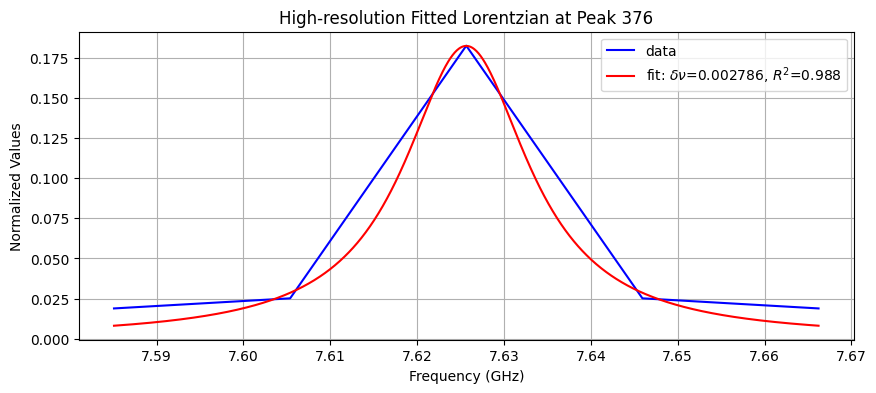

R^2= 0.987608911812103
dv 0.002785847096176976
Finesse 358.95724548999914


In [130]:
# plot csv file
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Load the CSV file
data = pd.read_csv(r'4\102mA\Broad.csv')

# Clean the column names by removing commas
data.columns = [col.replace(',', '') for col in data.columns]

# Convert the data to numeric values (removing commas in data)
data = data.replace({',': ''}, regex=True).apply(pd.to_numeric)

# Select the series with column name '20000'
series_column = '20000'
series_data = data[series_column]
limit = 600

# Plot the original series
plt.figure(figsize=(10, 4))
plt.plot(series_data)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title(f'FPI Data')
plt.grid(True)
plt.xlim(-10, limit)
plt.savefig(r'Latex\Figures\FPI_Data.png', dpi=600)
plt.show()

# Flip the data about the x-axis
flipped_series_data = -series_data

# Normalize the flipped data
normalized_flipped_series_data = (flipped_series_data - flipped_series_data.min()) / (flipped_series_data.max() - flipped_series_data.min())

# Find peaks in the flipped normalized series
peaks, _ = find_peaks(normalized_flipped_series_data, height = 0.1)

# Calculate distances between consecutive peaks
peak_distances = np.diff(peaks)

# Plot the flipped normalized series with peaks highlighted
plt.figure(figsize=(10, 4))
plt.plot(normalized_flipped_series_data)
plt.plot(peaks, normalized_flipped_series_data[peaks], 'o', label='Peaks')
plt.xlabel('Index')
plt.ylabel('Normalized Values')
plt.title(f'Flipped & Normalized FPI Peaks')

# Annotate the peaks
for peak in peaks:
    plt.annotate(peak, (peak, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

plt.legend()
plt.grid(True)
plt.xlim(-10,limit)
plt.savefig(r'Latex\Figures\FPI_Peaks.png', dpi=600)
plt.show()

# Compute the average distance between peaks
average_peak_distance = np.mean(peak_distances)
GHz_per_index = 1/ average_peak_distance
print(f'Average distance between peaks: {average_peak_distance}')
print(f'GHz per index: {GHz_per_index}')

# Compute the x-values in GHz
x_values_GHz = np.arange(len(normalized_flipped_series_data)) * GHz_per_index

# Plot the flipped normalized series with peaks highlighted
plt.figure(figsize=(10, 4))
plt.plot(x_values_GHz, normalized_flipped_series_data)
plt.plot(peaks * GHz_per_index, normalized_flipped_series_data[peaks], 'o', label='Peaks')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Values')
plt.title(f'Flipped & Normalized FPI Peaks')

# Annotate the peaks
for peak in peaks:
    plt.annotate(f'{peak * GHz_per_index:.2f}', (peak * GHz_per_index, normalized_flipped_series_data[peak]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, rotation=0)

plt.legend()
plt.grid(True)
plt.xlim(-10 * GHz_per_index, limit * GHz_per_index)
plt.savefig(r'Latex\Figures\FPI_Peaks.png', dpi=600)
plt.show()


# Define the Lorentzian function with an amplitude parameter
def lorentzian(x, x0, dv, C):
    return  C / ((x - x0)**2 + (np.pi*dv)**2)

peak_index = peaks[4]
window_size = 2  # Adjust as needed
window_indices = range(max(0, peak_index - window_size), min(len(normalized_flipped_series_data), peak_index + window_size + 1))
window_x = x_values_GHz[window_indices]
window_y = normalized_flipped_series_data[window_indices]

# Initial parameter estimates
x0_initial = x_values_GHz[peak_index]  # center frequency of the peak
gamma_initial = 0.1  # width of the peak
C_initial = max(window_y)  # height of the peak

# Now you can use A_initial in your initial parameter estimates
p0 = [x0_initial, gamma_initial, C_initial]

# Fit the Lorentzian function to the data in the window
popt, _ = curve_fit(lorentzian, window_x, window_y, p0=p0)

# Calculate the R^2 score for the original fit
predicted_y = lorentzian(window_x, *popt)
r2 = r2_score(window_y, predicted_y)


# Plot the original data and the fitted function for the window only
plt.figure(figsize=(10, 4))
plt.plot(window_x, window_y, 'b-', label='data')
plt.plot(window_x, predicted_y, 'r-', label=r'fit: $\delta \nu$=%5.6f, $R^2$=%5.3f' % (popt[1], r2))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Values')
plt.title(f'Fitted Lorentzian at Peak {peak_index}')
plt.legend()
plt.grid(True)
plt.show()

# Generate high-resolution x-values
high_res_x = np.linspace(window_x.min(), window_x.max(), 1000)

# Calculate the corresponding y-values using the fitted parameters
high_res_y = lorentzian(high_res_x, *popt)

# Plot the original data and the high-resolution fitted function
plt.figure(figsize=(10, 4))
plt.plot(window_x, window_y, 'b-', label='data')
plt.plot(high_res_x, high_res_y, 'r-', label=r'fit: $\delta \nu$=%5.6f, $R^2$=%5.3f' % (popt[1], r2))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Normalized Values')
plt.title(f'High-resolution Fitted Lorentzian at Peak {peak_index}')
plt.legend()
plt.grid(True)
plt.show()

print('R^2=', r2)
print('dv', popt[1])
print('Finesse', 1/popt[1])